In [1]:
%load_ext autoreload

In [3]:
%autoreload 2

import sys
sys.path.append('..')

from jax import numpy as jnp
import jax
import time
from scipy.integrate import quad, dblquad
import equinox as eqx
import jax_cosmo as jc
from quadax import quadgk, quadcc, quadts, romberg
from functools import partial

In [4]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.animation as animation 
from numpy import loadtxt
from diffrax import Kvaerno5, Tsit5
%matplotlib inline

from plot_params import params
#pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
from linx.background import BackgroundModel
from linx.nuclear import NuclearRates 
from linx.abundances import AbundanceModel
from linx.reactions import Reaction
from linx.thermo import T_g 
from linx.const import mn, mp, eta0, hbar, me, aFS, NE_pd, NE_min
from scipy.integrate import odeint, solve_ivp, simpson, cumulative_simpson
from linx.pd_rates import decay_model
from linx.injected_spec import InjectedSpectrum
from timeit import timeit
eps = 1e-3
Emin = 1.5 # MeV
Ephb_T_max = 200

## Double Photon Rate

In [6]:
E_grid = jnp.logspace(jnp.log(Emin), jnp.log(5), 150, base=jnp.e)

In [7]:
@jax.jit
def f_thermal_photon_spec(ep, T):
    """Calculates the thermal photon spectrum ie the photon bath

    Parameters
    ----------
    ep: float
        Energy which to integrate over (MeV)
    T: float
        temperature (MeV)

    Returns
    -------
    float
        thermal photon spectrum (MeV^2)
    """

    return (ep**2)/jnp.pi**2 * 1/(jnp.exp(ep/T) - 1)

@jax.jit
def dpr_gk(E, T):
    @jax.jit
    def inside_int(s):
        s = jnp.exp(s)
        b = jnp.sqrt(1 - (4*me**2)/s)
        dp_cross_section = jnp.pi * aFS**2 /(2*me**2) * (1-b**2) * ((3-b**4) * jnp.log((1+b)/(1-b)) - 2*b *(2-b**2))  
        return dp_cross_section * s * s  

    @jax.jit
    def integral_of_inside(ep):
        return quadgk(inside_int, [jnp.log(4*me**2), jnp.log(4*E* ep)], epsrel = eps, epsabs=0)[0]

    @jax.jit
    def outside_integral(ep, T):
        ep = jnp.exp(ep)
        return integral_of_inside(ep) * f_thermal_photon_spec(ep, T)/ep


    ep_ll = jnp.log((me**2)/E)
    ep_ul = jnp.log(Ephb_T_max*T)

    #I_dp_pp = 1/(8*E**2) * dblquad(dpr_integrand, ep_ll, ep_ul, lambda x: jnp.log(4*me**2), lambda x: jnp.log(4*E) + x, epsrel=eps, epsabs=0, args=(T,))[0]
    I_dp_pp = 1/(8*E**2) * quadgk(outside_integral, [ep_ll, ep_ul], epsrel=eps, epsabs=0, args=(T,))[0]

    #return I_dp_pp
    return jnp.select([E < (me**2)/(50*T)], [0], default=I_dp_pp)


In [8]:
@jax.jit
def dpr_trapz(E, T):
    @jax.jit
    def inside_int(s):
        s = jnp.exp(s)
        b = jnp.sqrt(1 - (4*me**2)/s)
        dp_cross_section = jnp.pi * aFS**2 /(2*me**2) * (1-b**2) * ((3-b**4) * jnp.log((1+b)/(1-b)) - 2*b *(2-b**2))  
        return dp_cross_section * s * s  

    @jax.jit
    def integral_of_inside(ep):
        s_values = jnp.linspace(jnp.log(4*me**2), jnp.log(4*E* ep), 200)
        integrand_values = inside_int(s_values)
        return jnp.trapezoid(integrand_values, s_values)

    @jax.jit
    def outside_integral(ep, T):
        ep = jnp.exp(ep)
        return integral_of_inside(ep) * f_thermal_photon_spec(ep, T)/ep

    ep_ll = jnp.log((me**2)/E)
    ep_ul = jnp.log(Ephb_T_max*T)

    ep_values = jnp.linspace(ep_ll, ep_ul, 200)
    integrand_values = outside_integral(ep_values, T)
    I_dp_pp = 1/(8*E**2) * jnp.trapezoid(integrand_values, ep_values)

    return jnp.select([E < (me**2)/(50*T)], [0], default=I_dp_pp)

In [9]:
@jax.jit
def dpr_gk_trapz(E, T):

    @jax.jit
    def integral_of_inside(ep):
        s_log = jnp.linspace(jnp.log(4*me**2), jnp.log(4*E* ep), 200)
        s = jnp.exp(s_log)
        b = jnp.sqrt(1 - (4*me**2)/s)
        dp_cross_section = jnp.pi * aFS**2 /(2*me**2) * (1-b**2) * ((3-b**4) * jnp.log((1+b)/(1-b)) - 2*b *(2-b**2))  

        return jnp.trapezoid(dp_cross_section * s * s  , s_log)

    @jax.jit
    def outside_integral(ep, T):
        ep = jnp.exp(ep)
        return integral_of_inside(ep) * f_thermal_photon_spec(ep, T)/ep


    ep_ll = jnp.log((me**2)/E)
    ep_ul = jnp.log(Ephb_T_max*T)

    #I_dp_pp = 1/(8*E**2) * dblquad(dpr_integrand, ep_ll, ep_ul, lambda x: jnp.log(4*me**2), lambda x: jnp.log(4*E) + x, epsrel=eps, epsabs=0, args=(T,))[0]
    I_dp_pp = 1/(8*E**2) * quadgk(outside_integral, [ep_ll, ep_ul], epsrel=eps, epsabs=0, args=(T,))[0]

    #return I_dp_pp
    return jnp.select([E < (me**2)/(50*T)], [0], default=I_dp_pp)


In [10]:
@jax.jit
def F_func(E, Ep, ep):   
        
        G_ep = 4*ep*Ep/(me**2)
        q = E/(G_ep*(Ep-E))
        F = 2*q*jnp.log(q) + (1+2*q)*(1-q) + G_ep**2 * q**2 * (1 - q)/(2+2*G_ep*q)

        return F

@jax.jit
def ic_gk_trapz(E, T):
    
    @jax.jit
    def integral_of_inside(ep, E):
        s = jnp.linspace(ep, 4*ep*E**2 /(me**2 + 4*ep*E), 200)
        return jnp.trapezoid(F_func(s, E, ep), s)

        
    @jax.jit
    def outside_integral(ep, T, E):
        return integral_of_inside(ep, E) * f_thermal_photon_spec(ep, T)/ep
    
    ep_ll = 0
    ep_ul = jnp.minimum(E - (me**2)/(4*E), Ephb_T_max*T)
    #E_ph_ll = lambda x: x
    #E_ph_ul = lambda x: 4*x*E**2 /(me**2 + 4*x*E)

    #return 2*jnp.pi*aFS**2 /E**2 * dblquad(icre_integrand, ep_ll, ep_ul, E_ph_ll, E_ph_ul,  epsrel=eps, epsabs=0, args=(E, T))[0]
    return 2*jnp.pi*aFS**2 /E**2 * quadgk(outside_integral, [ep_ll, ep_ul], epsrel=eps, epsabs=0, args=(T, E))[0]

def ic_gk(E, T):
    
    @jax.jit
    def inside_int(E_ph, E, ep):
        return F_func(E_ph, E, ep)
    
    @jax.jit
    def integral_of_inside(ep, E):
        return quadgk(inside_int, [ep, 4*ep*E**2 /(me**2 + 4*ep*E)], epsrel = eps, epsabs=0, args = (E, ep))[0]

    @jax.jit
    def outside_integral(ep, T, E):
        return integral_of_inside(ep, E) * f_thermal_photon_spec(ep, T)/ep
    
    ep_ll = 0
    ep_ul = jnp.minimum(E - (me**2)/(4*E), Ephb_T_max*T)
    #E_ph_ll = lambda x: x
    #E_ph_ul = lambda x: 4*x*E**2 /(me**2 + 4*x*E)

    #return 2*jnp.pi*aFS**2 /E**2 * dblquad(icre_integrand, ep_ll, ep_ul, E_ph_ll, E_ph_ul,  epsrel=eps, epsabs=0, args=(E, T))[0]
    return 2*jnp.pi*aFS**2 /E**2 * quadgk(outside_integral, [ep_ll, ep_ul], epsrel=eps, epsabs=0, args=(T, E))[0]

def ic_gk_trapz_nojit(E, T):
    
    @jax.jit
    def integral_of_inside(ep, E):
        s = jnp.linspace(ep, 4*ep*E**2 /(me**2 + 4*ep*E), 200)
        return jnp.trapezoid(F_func(s, E, ep), s)

        
    @jax.jit
    def outside_integral(ep, T, E):
        return integral_of_inside(ep, E) * f_thermal_photon_spec(ep, T)/ep
    
    ep_ll = 0
    ep_ul = jnp.minimum(E - (me**2)/(4*E), Ephb_T_max*T)
    #E_ph_ll = lambda x: x
    #E_ph_ul = lambda x: 4*x*E**2 /(me**2 + 4*x*E)

    #return 2*jnp.pi*aFS**2 /E**2 * dblquad(icre_integrand, ep_ll, ep_ul, E_ph_ll, E_ph_ul,  epsrel=eps, epsabs=0, args=(E, T))[0]
    return 2*jnp.pi*aFS**2 /E**2 * quadgk(outside_integral, [ep_ll, ep_ul], epsrel=eps, epsabs=0, args=(T, E))[0]



In [26]:
E_grid = jnp.logspace(jnp.log(Emin), jnp.log(30), 200, base=jnp.e)

In [27]:
%timeit jax.vmap(ic_gk_trapz, in_axes=(0, None))(E_grid, 0.001)

KeyboardInterrupt: 

In [16]:
%timeit jax.jit(jax.vmap(ic_gk_trapz_nojit, in_axes=(0, None)))(E_grid, 0.001).block_until_ready()

1.3 s ± 46.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
mm = ic_gk_trapz
v = partial(jax.vmap, in_axes=(0, None))

for f in [v(jax.jit(mm)), jax.jit(v(mm)), v(mm)]:
  run = lambda: f(E_grid, 0.001).block_until_ready()
  t = timeit(run, setup=run, number=20)
  print(f'{t:.3f}')

8.964
8.965
8.998


In [ ]:
timeit(jax.jit(jax.vmap(ic_gk_trapz, in_axes=(0, None)))(E_grid, 0.001).block_until_ready(), number = 100)

ValueError: stmt is neither a string nor callable

In [10]:
ic_gk(5, 0.01)

Array(2.29960228e-10, dtype=float64)

In [11]:
ic_gk_trapz(5, 0.01)

Array(2.29959865e-10, dtype=float64)

In [12]:
InjSpec = InjectedSpectrum()

In [21]:
InjSpec.dphoton_pair_prod_rate(5, 0.01).block_until_ready()

Array(1.72726845e-12, dtype=float64)

In [22]:
InjSpec.inverse_compton_rate(5, 0.01)

Array(2.29959865e-10, dtype=float64)

In [ ]:
%timeit InjSpec.inverse_compton_rate(5, 0.01).block_until_ready()

1.58 ms ± 38.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


: 

In [9]:
dpr_trapz(5, 0.01)

Array(1.72718986e-12, dtype=float64)

In [10]:
dpr_gk(5, 0.01)

Array(1.7273822e-12, dtype=float64)

In [11]:
dpr_gk_trapz(5, 0.01)

Array(1.72726833e-12, dtype=float64)

In [12]:
%timeit jax.vmap(dpr_gk_trapz, in_axes = (0, None))(E_grid, 0.01)

660 μs ± 254 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
gk_trapz = jax.vmap(dpr_gk_trapz, in_axes = (0, None))(E_grid, 0.01)
gk = jax.vmap(dpr_gk, in_axes = (0, None))(E_grid, 0.01)
trapz = jax.vmap(dpr_trapz, in_axes = (0, None))(E_grid, 0.01)

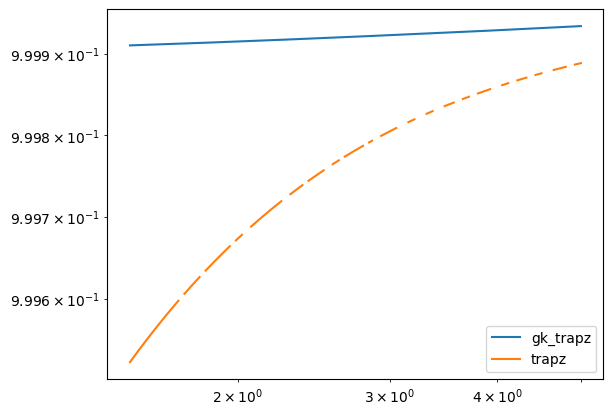

In [22]:
plt.loglog(E_grid, gk_trapz/gk, label = "gk_trapz")
plt.loglog(E_grid, trapz/gk, label = "trapz")
plt.legend()

In [40]:
# Vectorize the dpr_gk function
dpr_gk_vectorized = jax.vmap(dpr_gk, in_axes=(0, None))

# Run the vectorized function with the vector E_grid
result = dpr_gk_vectorized(E_grid, 0.01)
result.block_until_ready()

Array([1.45410677e-17, 1.66698965e-17, 1.90888957e-17, 2.18345345e-17,
       2.49474529e-17, 2.84728864e-17, 3.24611302e-17, 3.69680415e-17,
       4.20555870e-17, 4.77924345e-17, 5.42545951e-17, 6.15261173e-17,
       6.96998366e-17, 7.88781854e-17, 8.91740648e-17, 1.00711784e-16,
       1.13628070e-16, 1.28073154e-16, 1.44211933e-16, 1.62225217e-16,
       1.82311069e-16, 2.04686226e-16, 2.29587629e-16, 2.57274047e-16,
       2.88027811e-16, 3.22156660e-16, 3.59995701e-16, 4.01909497e-16,
       4.48294271e-16, 4.99580252e-16, 5.56234156e-16, 6.18761807e-16,
       6.87710902e-16, 7.63673940e-16, 8.47291296e-16, 9.39254466e-16,
       1.04030957e-15, 1.15126056e-15, 1.27297353e-15, 1.40638028e-15,
       1.55248257e-15, 1.71235638e-15, 1.88715645e-15, 2.07812098e-15,
       2.28657655e-15, 2.51394317e-15, 2.76173966e-15, 3.03158915e-15,
       3.32522477e-15, 3.64449565e-15, 3.99137304e-15, 4.36795668e-15,
       4.77648140e-15, 5.21932386e-15, 5.69900962e-15, 6.21822030e-15,
      

In [7]:
dpr_gk(5, 0.01).block_until_ready()

Array(1.7273822e-12, dtype=float64)

In [8]:
@jax.jit
def r_loops(E_grid):
    r_list = jnp.zeros(len(E_grid))
    for i, E in enumerate(E_grid):
        r_list.at[i].set(dpr_gk(E, 0.01))
    return r_list

In [16]:
r_vmap = partial(jax.vmap, in_axes=(0, None))

In [10]:
%timeit r_loops(E_grid).block_until_ready()

The slowest run took 105.01 times longer than the fastest. This could mean that an intermediate result is being cached.
69.6 μs ± 132 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
timeit.timeit(dpr_gk(5, 0.01)

11.6 ms ± 269 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
jax.vmap(dpr_gk, in_axes=(0, None))(E_grid, 0.01)

Array([1.45410758e-17, 1.66699056e-17, 1.90889060e-17, 2.18345462e-17,
       2.49474661e-17, 2.84729013e-17, 3.24611473e-17, 3.69680608e-17,
       4.20556086e-17, 4.77924588e-17, 5.42546223e-17, 6.15261478e-17,
       6.96998707e-17, 7.88782236e-17, 8.91741074e-17, 1.00711832e-16,
       1.13628123e-16, 1.28073213e-16, 1.44211998e-16, 1.62225290e-16,
       1.82311150e-16, 2.04686320e-16, 2.29587733e-16, 2.57274162e-16,
       2.88027938e-16, 3.22156801e-16, 3.59995857e-16, 4.01909669e-16,
       4.48294460e-16, 4.99580461e-16, 5.56234387e-16, 6.18762060e-16,
       6.87711180e-16, 7.63674245e-16, 8.47291631e-16, 9.39254833e-16,
       1.04030988e-15, 1.15126089e-15, 1.27297389e-15, 1.40638068e-15,
       1.55248305e-15, 1.71235690e-15, 1.88715702e-15, 2.07812161e-15,
       2.28657722e-15, 2.51394390e-15, 2.76174045e-15, 3.03159000e-15,
       3.32522569e-15, 3.64449665e-15, 3.99137411e-15, 4.36795784e-15,
       4.77648265e-15, 5.21932521e-15, 5.69901107e-15, 6.21822185e-15,
      

In [ ]:
r_mapped = jax.vmap(dpr_gk, in_axes=(0, None))
r_mapped(E_grid, 0.01).block_until_ready()

Array([1.45410758e-17, 1.66699056e-17, 1.90889060e-17, 2.18345462e-17,
       2.49474661e-17, 2.84729013e-17, 3.24611473e-17, 3.69680608e-17,
       4.20556086e-17, 4.77924588e-17, 5.42546223e-17, 6.15261478e-17,
       6.96998707e-17, 7.88782236e-17, 8.91741074e-17, 1.00711832e-16,
       1.13628123e-16, 1.28073213e-16, 1.44211998e-16, 1.62225290e-16,
       1.82311150e-16, 2.04686320e-16, 2.29587733e-16, 2.57274162e-16,
       2.88027938e-16, 3.22156801e-16, 3.59995857e-16, 4.01909669e-16,
       4.48294460e-16, 4.99580461e-16, 5.56234387e-16, 6.18762060e-16,
       6.87711180e-16, 7.63674245e-16, 8.47291631e-16, 9.39254833e-16,
       1.04030988e-15, 1.15126089e-15, 1.27297389e-15, 1.40638068e-15,
       1.55248305e-15, 1.71235690e-15, 1.88715702e-15, 2.07812161e-15,
       2.28657722e-15, 2.51394390e-15, 2.76174045e-15, 3.03159000e-15,
       3.32522569e-15, 3.64449665e-15, 3.99137411e-15, 4.36795784e-15,
       4.77648265e-15, 5.21932521e-15, 5.69901107e-15, 6.21822185e-15,
      

In [95]:
# simple square function for scalar number
def square_function(x) :
  return x*x

# This is example of highly inefficient code
# Jax did not allow direct in-place operator, such as a[0] = 1
# Jax must replace the array when updating, a = a.at[0].set(1)
def square_vector_manual(x) :
  temp_x = x
  for i in range(len(temp_x)) :
    squared_x = square_function(temp_x[i])
    temp_x = temp_x.at[i].set(squared_x)
  return temp_x

# We can implement the vectorized implementation
# This look easy, but it can become very hard 
# when the function is hard to vectorize
def square_vector_vectorized(x) :
  return x*x

# Other way is to use vmap
# vmap can map a function so it can process higher dimension
square_vector_map = jax.vmap(square_function)

In [97]:
x_now = jnp.arange(1500)

In [104]:
v = partial(jax.vmap)

In [107]:
# use block_until_ready() because 
# https://jax.readthedocs.io/en/latest/async_dispatch.html#async-dispatch
# which say, it's to measure the true cost of the operation
print(square_vector_manual(x_now))
%timeit square_vector_manual(x_now).block_until_ready()
# >> [      0       1       4 ... 2241009 2244004 2247001]
# >> 1.25 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

print(square_vector_vectorized(x_now))
%timeit square_vector_vectorized(x_now).block_until_ready()
# >> [      0       1       4 ... 2241009 2244004 2247001]
# >> 9.38 µs ± 167 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

print(square_vector_map(x_now))
%timeit jax.jit(v(square_function))(x_now).block_until_ready()
# >> [      0       1       4 ... 2241009 2244004 2247001]
# >> 812 µs ± 142 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# using map function can fasten it up a lot

[      0       1       4 ... 2241009 2244004 2247001]
963 ms ± 240 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
[      0       1       4 ... 2241009 2244004 2247001]
14.3 μs ± 628 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
[      0       1       4 ... 2241009 2244004 2247001]
17.8 ms ± 537 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [99]:
square_vector_manual_jit = jax.jit(square_vector_manual)
square_vector_vectorized_jit = jax.jit(square_vector_vectorized)
square_vector_map_jit = jax.jit(square_vector_map)

In [109]:
# Here comes the jit function, we can compile the code into XLA
# https://www.tensorflow.org/xla
# We can use the map function and then compile it
print(square_vector_map_jit(x_now))
%timeit square_vector_map_jit(x_now).block_until_ready()
# >> [      0       1       4 ... 2241009 2244004 2247001]
# >> 9 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
# The speed become very fast!

# we can also use jit for vectorized fucntion
# speed improves, but not as drastic as using map and jit function
print(square_vector_vectorized_jit(x_now))
%timeit square_vector_vectorized_jit(x_now).block_until_ready()
# >> [      0       1       4 ... 2241009 2244004 2247001]
# >> 7.21 µs ± 153 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

# One cool thing is that we can even use jit for the manual code we create!
# The speed improvement is very drastic!
print(square_vector_manual_jit(x_now))
%timeit square_vector_manual_jit(x_now).block_until_ready()
# >> [      0       1       4 ... 2241009 2244004 2247001]
# >> 7.37 µs ± 74 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

[      0       1       4 ... 2241009 2244004 2247001]
11.7 μs ± 941 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
[      0       1       4 ... 2241009 2244004 2247001]
10.3 μs ± 1.26 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
[      0       1       4 ... 2241009 2244004 2247001]
163 μs ± 30.5 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
